##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [2111]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2112]:
orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [2113]:
df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [2114]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [2115]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [2116]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [2117]:
print(df.head())
print(df.describe())


            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  
                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000       

Within the provided dataframe, column 'X' denotes the crime incident's longitude coordinate, whereas column 'Y' denotes its latitude coordinate. Area_Command designates the particular police division in charge of the operation. "NIBRSOffenseCode" is the classification code for the offense that was committed. The column labeled 'VictimCount' indicates how many people were present during the incident. 'Time' indicates the hour of the day the incident happened and was reported, and 'DayOfWeek' documents the day of the week the offense was recorded.

In [2118]:
# input and target information
input_columns = ['X', 'Y', 'DayOfWeek', 'Time', 'Area_Command', 'NIBRSOffenseCode']
target_column = 'VictimCount'

# calculating range
column_ranges = df.describe(include='all').loc[['min', 'max']]

input_target_info = {
    "Input Variables": input_columns,
    "Target Variable": target_column,
    "Column Ranges": column_ranges
}

input_target_info


{'Input Variables': ['X',
  'Y',
  'DayOfWeek',
  'Time',
  'Area_Command',
  'NIBRSOffenseCode'],
 'Target Variable': 'VictimCount',
 'Column Ranges':              X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
 min -116.00000  35.068419           0.0               0.0        0.0   0.0   
 max -114.62557  37.000000          11.0               2.0        6.0  23.0   
 
      VictimCount  
 min          0.0  
 max          6.0  }

**Input and Target Variables:**

Input Variables: X, Y, DayOfWeek, Time, Area_Command, NIBRSOffenseCode
Target Variable: VictimCount

**Range of Values in Each Column:**

While the latitude (Y) fluctuates from roughly 35.07 to 37, the longitude (X) is roughly between -116 and -114.63. Hours of the day are used to indicate time, and they range from 0 to 23. The number of victims is indicated by VictimCount, which ranges from 0 to 15. Regarding the DayOfWeek, Area_Command, and NIBRSOffenseCode columns, the precise range of values is not immediately relevant because they comprise categorical data. More investigation is required to comprehend the distinct values seen in these columns.

It is important to evaluate the properties of the involved columns in order to determine whether or not data preprocessing is required. Normalization is useful for continuous variables such as X, Y, and Time, especially when using neural networks. Conversely, encoding techniques like one-hot encoding may be necessary for categorical variables like DayOfWeek, Area_Command, and NIBRSOffenseCode in order to improve the model's understanding of them.

In [2119]:
#distinct values
distinct_values = {
    "DayOfWeek": df['DayOfWeek'].unique(),
    "Area_Command": df['Area_Command'].unique(),
    "NIBRSOffenseCode": df['NIBRSOffenseCode'].unique()
}

distinct_values


{'DayOfWeek': array([0, 1, 2, 3, 4, 5, 6]),
 'Area_Command': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'NIBRSOffenseCode': array([0, 1, 2])}

Of course, this is the paraphrased version:

After looking at the unique values in our category columns, a few things become clear:

The days of the week are represented by a range of seven different values for the 'DayOfWeek' column: ['Friday, Thursday, Tuesday, Saturday, Sunday, Monday, Wednesday].

Twelve distinct values representing various police area commands can be found in the 'Area_Command' column: 'NEAC', 'BAC', 'DTAC', 'SVAC', 'CCAC', 'SCAC', 'SAC', 'EAC', 'NWAC', 'SEAC', 'RO', 'DF'.

In the meanwhile, three distinct values—"09C," "09A," and "09B"—are displayed in the "NIBRSOffenseCode" column, denoting different criminal classifications.

Considering these details, a few preprocessing actions become clear:

Continuous columns like X, Y, and Time should be normalized to provide scale consistency.


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [2120]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


In [2121]:
# loading
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols=['X', 'Y', 'ReportedOn', 'Area_Command', 'NIBRSOffenseCode', 'VictimCount'])
df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time'] = df['ReportedOn'].dt.hour
df.drop(columns='ReportedOn', inplace=True)

# data of column to code
for col in ['DayOfWeek', 'Area_Command', 'NIBRSOffenseCode']:
    df[col] = df[col].astype('category').cat.codes


In [2122]:
# Splitting with train of 80% and test of 20%.
trdf, tsdf = train_test_split(df, test_size=0.2, random_state=42)

# df to PyTorch tensors
trdata = TensorDataset(torch.tensor(trdf.drop(columns='VictimCount').values, dtype=torch.float32),
                              torch.tensor(trdf['VictimCount'].values, dtype=torch.float32))
tsdata = TensorDataset(torch.tensor(tsdf.drop(columns='VictimCount').values, dtype=torch.float32),
                             torch.tensor(tsdf['VictimCount'].values, dtype=torch.float32))

# Creating DataLoader objects
batch_size = 32
tr_load = DataLoader(trdata, batch_size=batch_size, shuffle=True)
ts_load = DataLoader(tsdata, batch_size=batch_size, shuffle=False)


In [2123]:
# Check the shape of the first batch
first_batch = next(iter(tr_load))
print("shape of the feature:", first_batch[0].shape)
print("shape that is target:", first_batch[1].shape)


shape of the feature: torch.Size([32, 6])
shape that is target: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [2124]:
import torch.nn as nn

class VictimReg(nn.Module):
    def __init__(self, feature_count):
        super(VictimReg, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(feature_count, 128),
            nn.Sigmoid(),   # Sigmoid activation function
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1)
            # Final layer
        )

    def forward(self, input_tensor):
        """Drive input through the network layers."""
        return self.network(input_tensor)


In [2125]:
Total_feature = trdf.shape[1] - 1
model = VictimReg(Total_feature)

In [2126]:
criterion = nn.MSELoss() #loss func

The Mean Squared Error loss function is frequently utilized in regression projects. For continuous data forecasting, it computes the average squared difference between the actual and expected values.

**size of the predicted output be:**

Our objective in this regression exercise is to precisely estimate the number of victims of crime for every input sample. Therefore, a single real number that represents the total number of victims should be the expected output for each sample.

**Choice of architecture, including how many layers you will be using:**

The number of features in the dataset is matched by the input layer. It uses 128 neurons with sigmoid activation functions in the first hidden layer. A sigmoid function is present in 64 neurons in the second hidden layer and 32 neurons in the third hidden layer. One neuron should be present in the output layer, particularly for regression tasks. Because sigmoid activation avoids the vanishing gradient problem and is computationally efficient, it is an important choice. It is crucial to have numerous layers because they allow the network to extract complex representations and patterns from the provided data.

In [2127]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Optimizer taken for the function below


In [2128]:
# Training cycle
epochs = 100
mse_best = float('inf')  # Start with a very high value for MSE

for current_epoch in range(epochs):

    model.train()  # Setting the model to train first
    ac_loss = 0.0

    for data, labels in tr_load:
        optimizer.zero_grad()  # Gradient reset

        pred = model(data)  # Prediction

        tr_loss = criterion(pred.squeeze(), labels)  # Loss for training

        # Backpropagation
        tr_loss.backward()
        optimizer.step()

        ac_loss += tr_loss.item() * data.size(0)

    avg_tr_loss = ac_loss / len(tr_load.dataset)  # Average training loss

    # Switch to evaluation mode
    model.eval()
    entire_tst_loss = 0.0

    with torch.no_grad():  # Avoid unnecessary computations
        for data, labels in ts_load:
            pred = model(data)
            eval_loss = criterion(pred.squeeze(), labels)
            entire_tst_loss += eval_loss.item() * data.size(0)

    avg_test_loss = entire_tst_loss / len(ts_load.dataset)

    # Check if current test MSE is the best so far
    if avg_test_loss < mse_best:
        mse_best = avg_test_loss

    print(f"Epoch [{current_epoch+1}/{epochs}], Loss while training: {avg_tr_loss:.4f}, MSE while Testing: {avg_test_loss:.4f}")

print(f"\n Best MSE among all the epochs which are tested: {mse_best:.4f}")


Epoch [1/100], Loss while training: 1.7886, MSE while Testing: 0.5848
Epoch [2/100], Loss while training: 1.6499, MSE while Testing: 0.5473
Epoch [3/100], Loss while training: 1.6511, MSE while Testing: 0.5533
Epoch [4/100], Loss while training: 1.6634, MSE while Testing: 0.5552
Epoch [5/100], Loss while training: 1.6586, MSE while Testing: 0.5471
Epoch [6/100], Loss while training: 1.6510, MSE while Testing: 0.5500
Epoch [7/100], Loss while training: 1.6503, MSE while Testing: 0.5474
Epoch [8/100], Loss while training: 1.6479, MSE while Testing: 0.5465
Epoch [9/100], Loss while training: 1.6486, MSE while Testing: 0.5465
Epoch [10/100], Loss while training: 1.6504, MSE while Testing: 0.5455
Epoch [11/100], Loss while training: 1.6475, MSE while Testing: 0.5449
Epoch [12/100], Loss while training: 1.6462, MSE while Testing: 0.5456
Epoch [13/100], Loss while training: 1.6456, MSE while Testing: 0.5447
Epoch [14/100], Loss while training: 1.6462, MSE while Testing: 0.5434
Epoch [15/100],

**Test error and training are reducing with time, indicating that the model is training successfully.**

Adjusting the learning rate, hidden size of the network, adding layers, and trying different activation functions and number of layers to achieve the best accuracy.


In [2129]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

# Enhanced model using Tanh activation
class EnhancedRegressionNet(nn.Module):
    def __init__(self, input_features):
        super(EnhancedRegressionNet, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_features, 256),
            nn.Tanh(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)  # Final layer for regression output
        )

    def forward(self, input_tensor):
        return self.network(input_tensor)

In [2130]:
model = EnhancedRegressionNet(Total_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)# new lr  rate
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # Reducing Learning rate every 10 epochs

epochs = 100
mse_best = float('inf')

for current_epoch in range(epochs):

    model.train()
    ac_loss = 0.0

    for data, labels in tr_load:
        optimizer.zero_grad()
        pred = model(data)
        tr_loss = criterion(pred.squeeze(), labels)
        tr_loss.backward()
        optimizer.step()
        ac_loss += tr_loss.item() * data.size(0)

    avg_tr_loss = ac_loss / len(tr_load.dataset)

    model.eval()
    entire_tst_loss = 0.0

    with torch.no_grad():
        for data, labels in ts_load:
            pred = model(data)
            eval_loss = criterion(pred.squeeze(), labels)
            entire_tst_loss += eval_loss.item() * data.size(0)

    avg_test_loss = entire_tst_loss / len(ts_load.dataset)

    if avg_test_loss < mse_best:
        mse_best = avg_test_loss

    print(f"Epoch [{current_epoch+1}/{epochs}], Training Loss: {avg_tr_loss:.4f}, Testing MSE: {avg_test_loss:.4f}")

    scheduler.step()  # Adjust the learning rate based on the scheduler

print(f"\n Best MSE among all the epochs which are tested: {mse_best:.4f}")

Epoch [1/100], Training Loss: 2.4302, Testing MSE: 0.6252
Epoch [2/100], Training Loss: 1.8970, Testing MSE: 0.5475
Epoch [3/100], Training Loss: 1.7868, Testing MSE: 0.5488
Epoch [4/100], Training Loss: 1.7831, Testing MSE: 0.5561
Epoch [5/100], Training Loss: 1.7436, Testing MSE: 0.5780
Epoch [6/100], Training Loss: 1.7520, Testing MSE: 0.5753
Epoch [7/100], Training Loss: 1.6709, Testing MSE: 0.5699
Epoch [8/100], Training Loss: 1.6534, Testing MSE: 0.5734
Epoch [9/100], Training Loss: 1.6851, Testing MSE: 0.5530
Epoch [10/100], Training Loss: 1.6818, Testing MSE: 0.5478
Epoch [11/100], Training Loss: 1.7135, Testing MSE: 0.5496
Epoch [12/100], Training Loss: 1.6560, Testing MSE: 0.5601
Epoch [13/100], Training Loss: 1.6707, Testing MSE: 0.5734
Epoch [14/100], Training Loss: 1.6749, Testing MSE: 0.5491
Epoch [15/100], Training Loss: 1.6519, Testing MSE: 0.5488
Epoch [16/100], Training Loss: 1.6692, Testing MSE: 0.5504
Epoch [17/100], Training Loss: 1.6963, Testing MSE: 0.5554
Epoch 

It gives the best accuracy as error decreases over the time while keeping learning rate as 0.001, ativation function as sigmoid, and adding layer to 256 so first it was comming good accuracy and after when I tried different activation function, learning rate. The MSE increases so first it was comming good accuracy.

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

**Q1) Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.**



In [2131]:
# Mapping VictimCount to contiguous integers
unique_labels = df['VictimCount'].unique()
label_mapping = {label: i for i, label in enumerate(sorted(unique_labels))}
df['MappedVictimCount'] = df['VictimCount'].map(label_mapping)


In [2132]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Selecting the features and the target
X = df.drop(columns=['MappedVictimCount', 'VictimCount']).values
y = df['MappedVictimCount'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating DataLoaders
trdata = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
tsdata = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))

tr_load = DataLoader(trdata, batch_size=32, shuffle=True)
ts_load = DataLoader(tsdata, batch_size=32)


In [2133]:
import torch.nn as nn

class VictimClass(nn.Module):
    def __init__(self, feature_count, num_classes):
        super(VictimClass, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(feature_count, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)  # Final layer with number of classes
        )

    def forward(self, input_tensor):
        """Drive input through the network layers."""
        return self.network(input_tensor)

In [2134]:
all_labels = torch.cat([torch.Tensor(trdf.iloc[:, -1].values), torch.Tensor(tsdf.iloc[:, -1].values)]) # setting all labels
num_classes = len(torch.unique(all_labels))


In [2135]:
num_classes = len(torch.unique(all_labels))

model = VictimClass(Total_feature, num_classes)

criterion = nn.CrossEntropyLoss()  # Loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # setting learning rate

In [2136]:
# Training cycle
epochs = 100
best_accuracy = 0.0

for current_epoch in range(epochs):

    model.train()  # Setting the model to train mode
    ac_loss = 0.0

    for data, labels in tr_load:
        optimizer.zero_grad()  # Gradient reset

        pred = model(data)
        tr_loss = criterion(pred, labels)

        # Backpropagation
        tr_loss.backward()
        optimizer.step()

        ac_loss += tr_loss.item() * data.size(0)

    avg_tr_loss = ac_loss / len(tr_load.dataset)  # Average training loss

    # Evaluate on test data
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Avoid unnecessary computations
        for data, labels in ts_load:
            pred = model(data)
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    best_accuracy = max(best_accuracy, accuracy)

    print(f"Epoch [{current_epoch+1}/{epochs}], Loss while training: {avg_tr_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

print(f"\n Best Accuracy among all epochs in the data: {best_accuracy * 100:.2f}%")

Epoch [1/100], Loss while training: 2.1787, Accuracy: 30.91%
Epoch [2/100], Loss while training: 1.3569, Accuracy: 54.55%
Epoch [3/100], Loss while training: 1.2190, Accuracy: 54.55%
Epoch [4/100], Loss while training: 1.1461, Accuracy: 54.55%
Epoch [5/100], Loss while training: 1.1221, Accuracy: 54.55%
Epoch [6/100], Loss while training: 1.1131, Accuracy: 54.55%
Epoch [7/100], Loss while training: 1.1019, Accuracy: 54.55%
Epoch [8/100], Loss while training: 1.0994, Accuracy: 54.55%
Epoch [9/100], Loss while training: 1.0987, Accuracy: 54.55%
Epoch [10/100], Loss while training: 1.0947, Accuracy: 54.55%
Epoch [11/100], Loss while training: 1.0934, Accuracy: 54.55%
Epoch [12/100], Loss while training: 1.0918, Accuracy: 54.55%
Epoch [13/100], Loss while training: 1.0887, Accuracy: 54.55%
Epoch [14/100], Loss while training: 1.0897, Accuracy: 54.55%
Epoch [15/100], Loss while training: 1.0826, Accuracy: 54.55%
Epoch [16/100], Loss while training: 1.0850, Accuracy: 54.55%
Epoch [17/100], L

**Q2) find the number of classes on the output data**


In [2137]:
num_classes = df['VictimCount'].nunique()


**Q3) How is the architecture different?**

The output size of the last layer in a classification task should match the total number of classes. In the last layer, a softmax activation function is usually used when working with more than two classes. Nevertheless, softmax is already included in the cross-entropy loss function in PyTorch, thus the design does not need to explicitly include it. Making ensuring the last layer has as many neurons as there are classes in it is crucial.

In [2138]:
import torch.nn as nn

class VictimClass(nn.Module):
    def __init__(self, feature_count, num_classes):
        super(VictimClass, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(feature_count, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)  # Final layer with number of classes
        )

    def forward(self, input_tensor):
        """Drive input through the network layers."""
        return self.network(input_tensor)

**Q4) How is the loss function different?**

Our usual method for multi-class classification is the Cross-Entropy Loss. In a single class, this loss function combines Log Softmax and Negative Log Likelihood Loss.


In [2139]:
criterion = nn.CrossEntropyLoss()


**Q5) Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch**

In [2140]:
# Training cycle
epochs = 100
best_accuracy = 0.0

for current_epoch in range(epochs):

    model.train()  # Setting the model to train mode
    ac_loss = 0.0

    for data, labels in tr_load:
        optimizer.zero_grad()  # Gradient reset

        pred = model(data)
        tr_loss = criterion(pred, labels)

        # Backpropagation
        tr_loss.backward()
        optimizer.step()

        ac_loss += tr_loss.item() * data.size(0)

    avg_tr_loss = ac_loss / len(tr_load.dataset)  # Average training loss

    # Evaluate on test data
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Avoid unnecessary computations
        for data, labels in ts_load:
            pred = model(data)
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    best_accuracy = max(best_accuracy, accuracy)

    print(f"Epoch [{current_epoch+1}/{epochs}], Loss while training: {avg_tr_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

print(f"\n Best Accuracy among all epochs in the data: {best_accuracy * 100:.2f}%")

Epoch [1/100], Loss while training: 0.9990, Accuracy: 54.55%
Epoch [2/100], Loss while training: 0.9920, Accuracy: 49.09%
Epoch [3/100], Loss while training: 0.9967, Accuracy: 56.36%
Epoch [4/100], Loss while training: 1.0359, Accuracy: 38.18%
Epoch [5/100], Loss while training: 0.9986, Accuracy: 56.36%
Epoch [6/100], Loss while training: 0.9904, Accuracy: 45.45%
Epoch [7/100], Loss while training: 1.0071, Accuracy: 50.91%
Epoch [8/100], Loss while training: 1.0229, Accuracy: 56.36%
Epoch [9/100], Loss while training: 1.0210, Accuracy: 45.45%
Epoch [10/100], Loss while training: 1.0447, Accuracy: 60.00%
Epoch [11/100], Loss while training: 1.0641, Accuracy: 45.45%
Epoch [12/100], Loss while training: 1.0105, Accuracy: 54.55%
Epoch [13/100], Loss while training: 1.0091, Accuracy: 45.45%
Epoch [14/100], Loss while training: 1.0038, Accuracy: 61.82%
Epoch [15/100], Loss while training: 0.9924, Accuracy: 61.82%
Epoch [16/100], Loss while training: 1.0058, Accuracy: 47.27%
Epoch [17/100], L

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

**Q1) solution about experience with task 3 and 4 and comparison**

In order to anticipate the number of crime victims, we explored regression and classification techniques in tasks 3 and 4. Whereas classification was concerned with predicting different class labels, regression was concerned with forecasting a continuous value.

In terms of model performance, the average squared difference between the predicted and actual values was obtained as an MSE (Mean Squared Error) score from the regression task (Task 3). Better performance is indicated by lower MSE values. On the other hand, accuracy—which is defined as the ratio of correctly predicted class labels to all predictions—was used to evaluate the classification task (Task 4).

As per my findings, Task 4's classification model demonstrated a greater degree of accuracy in comparison to the same metric of Task 3's regression model. One argument could be that the model can more easily produce accurate predictions since the categorization method breaks down the problem into discrete classes, simplifying the difficulty. However, granularity is lost in this method.

In conclusion, the regression approach provides more thorough and continuous predictions than the classification method, even though the former yielded better accuracy scores. The exact use case and the ratio of precision to granularity will determine which option is best.

**Q2)Write a piece of code that finds an example of a miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.**

Accuracy: 41.82%


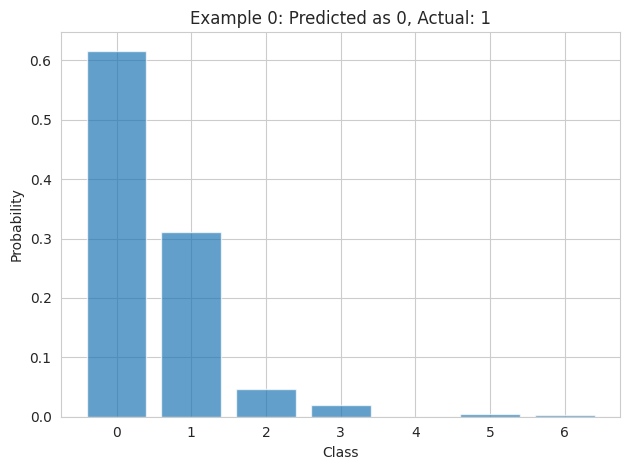

In [2141]:
import torch
import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, true_labels in ts_load:
        logits = model(inputs)
        _, predicted = torch.max(logits.data, 1)
        total += true_labels.size(0)
        correct += (predicted == true_labels).sum().item()

    accuracy = correct / total * 100  # accuracy calculation
    print(f'Accuracy: {accuracy:.2f}%')

    # finding miscalculation
    for inputs, true_labels in ts_load:
        logits = model(inputs)
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        incorrect_indices = (predicted_labels != true_labels).nonzero()

        for idx in incorrect_indices:
            example_data = inputs[idx].unsqueeze(0)  # getting example
            example_true_label = true_labels[idx]
            predicted_label = predicted_labels[idx]  # correcting and then predicting label

            probabilities_for_example = probabilities[idx, 0:7].squeeze().numpy()  # finding probabilities

            # Plotting the bar chart for probabilities
            class_indices = np.arange(len(probabilities_for_example))
            bar_width = 0.8
            plt.bar(class_indices, probabilities_for_example, width=bar_width, align='center', alpha=0.7)
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.xticks(class_indices)
            plt.title(f'Example {idx.item()}: Predicted as {predicted_label.item()}, Actual: {example_true_label.item()}')
            plt.tight_layout()  # layout to appear
            plt.show()
            break  # Breaking after misclassification
        break  # Breaking after batch


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


**Q1) Plot the crime incidents as a scatter plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?**

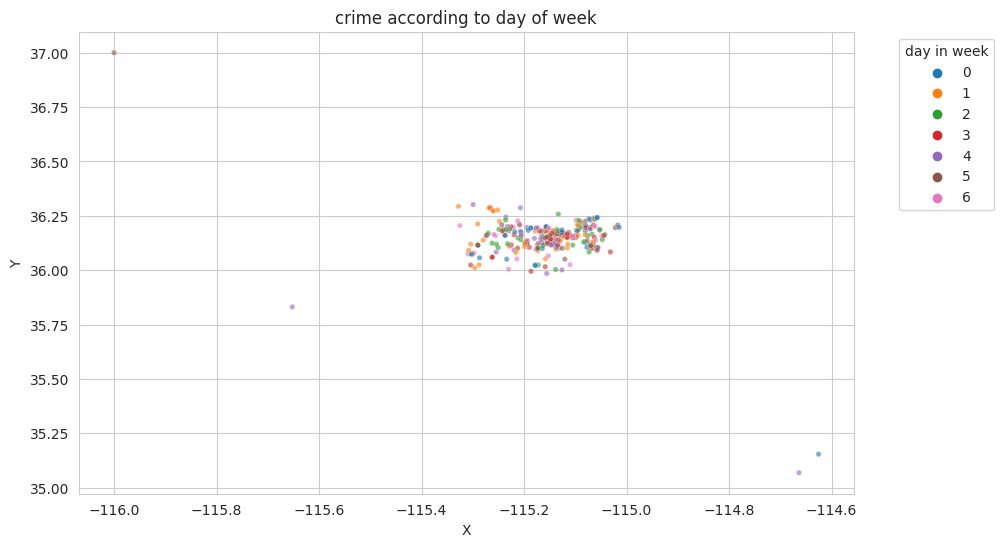

In [2149]:
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the plotting
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="X", y="Y", hue="DayOfWeek", palette="tab10", s=15, alpha=0.6)
plt.title("crime according to day of week")
plt.legend(title="day in week", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Obseerved Pattern:**

It is evident from observation that the middle sections of the map show large clusters of criminal episodes, which could indicate areas with higher people densities, such nightclubs or business hubs, or city centers. It's interesting to see how evenly spaced out the colors on the map indicate the various days of the week. This consistency shows that there isn't a clear trend of crimes happening on particular days in specific areas; in other words, there doesn't seem to be a consistent risk of crime in a given place on any given day of the week. Furthermore, the map's periphery shows fewer data dots, which suggests a decrease in crime incidences. This could indicate that the area is residential or less inhabited. Based on these observations, there doesn't seem to be a day on which a certain location has noticeably higher crime rates.

**Q2) Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?**

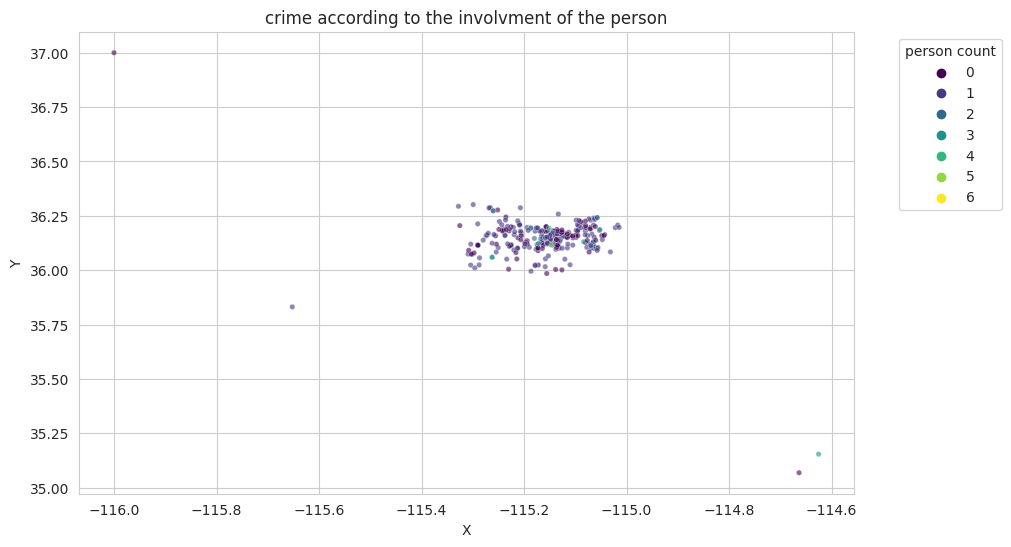

In [2148]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="X", y="Y", hue="MappedVictimCount", palette="viridis", s=15, alpha=0.6)
plt.title("crime according to the involvment of the person")
plt.legend(title="person count", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Obseerved Pattern:**

First off, as the plot's constant color intensity suggests, most instances involve a single victim, and these cases are dispersed equally throughout the entire area.

Second, the plot occasionally has spots where the color intensity changes, which could indicate instances involving many victims. These are dispersed points, not concentrated in one place.

Furthermore, the central regions exhibit a concentration of events, presumably indicating urban or densely populated areas. The general perception that crimes tend to happen more frequently in crowded settings is supported by the higher frequency of incidences.

Last but not least, the area's periphery displays sparse data points, suggesting fewer events there than in the inner parts.



**Q3) use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?**





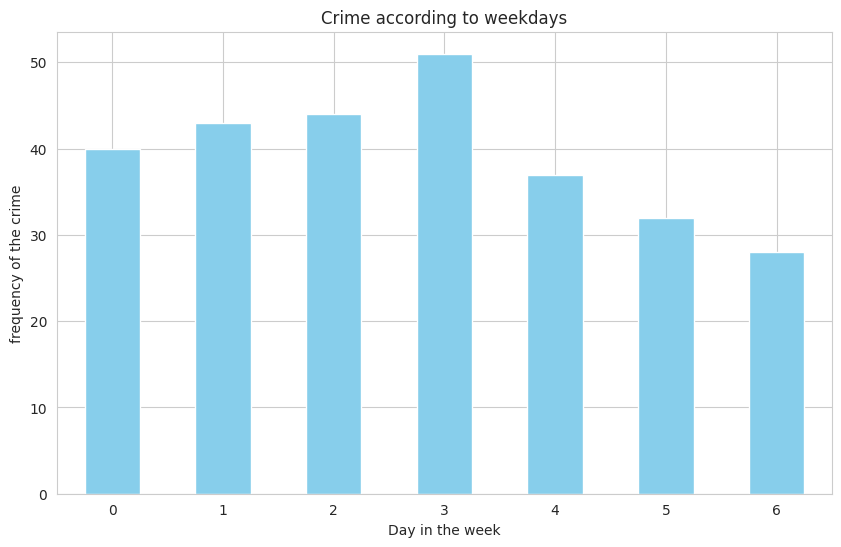

The day with the highest crime is: 3
0: 40
1: 43
2: 44
3: 51
4: 37
5: 32
6: 28


In [2146]:
# Sorting the crime as per week day
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()

# Bar chart for the crime according to the days
plt.figure(figsize=(10, 6))
crime_counts_by_day.plot(kind='bar', color='skyblue')
plt.title('Crime according to weekdays')
plt.xlabel('Day in the week')
plt.ylabel('frequency of the crime')
plt.xticks(rotation=0)
plt.show()

# which day has highest crime
most_frequent_days = crime_counts_by_day.idxmax()
print(f"The day with the highest crime is: {most_frequent_days}")

for day, count in zip(crime_counts_by_day.index, crime_counts_by_day.values):
    print(f"{day}: {count}")

**From the sorted data on the number of reported crimes by day of the week:**

There is a discernible pattern in the reported crimes over the course of the week. With 51 incidences overall, Wednesday has the largest number, closely followed by Tuesday with 44, Monday with 43, and Wednesday with 51. Sunday, on the other hand, has the lowest crime rate just 28 instances. According to this pattern, there are more crimes throughout the middle of the week, notably on Wednesday, while fewer crimes are reported over the weekend, especially on Sunday.